### Import des libraires
- Pandas : gestion heterogène array
- Numpy : gestion homogène array
- Torch : ML/DL pour création de nn, transformation audio
- Matplotlib : Pour plot des données
- Tqdm : bar de chargement entrainement

In [1]:
import csv
import os
from pathlib import Path

import torch
from torch import Tensor
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from typing import Dict, List, Tuple, Union

from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchaudio.transforms import MelSpectrogram
import torchaudio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchaudio.transforms as T

from tqdm import tqdm



Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x11013bc10>>
Traceback (most recent call last):
  File "/Users/robinbochu/.pyenv/versions/3.11.8/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
/Users/robinbochu/.pyenv/versions/3.11.8/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


On définit le device sur mps étant sur un silicon pour faire de la parralélisation

In [ ]:
device = torch.device("mps")

### Dataset
Contexte de la donnée:
On a 3 datasets utilisable : test, train, validated. J'ai donc décidé de les concaténer pour finalement avoir un dataset beaucoup plus grand comme ça on facilite la segmentation de la donnée : 80/20%

- Récupération de la donnée dans les fichier tsv
- Cleanning de la data (Valeurs null ou à 0)
- Filtre données : on ne garde que les target = 1, 2, 3 ou 4

In [ ]:
train_data = pd.read_csv('data/cv-corpus-7.0-singleword/fr/train.tsv',sep='\t')
train_data[['path', 'sentence']] = train_data[['path', 'sentence']].replace('', np.nan)
train_data_numbers = train_data[(train_data['sentence']=='un')|(train_data['sentence']=='deux')|(train_data['sentence']=='trois')|(train_data['sentence']=='quatre')]

test_data = pd.read_csv('data/cv-corpus-7.0-singleword/fr/test.tsv',sep='\t')
test_data[['path', 'sentence']] = test_data[['path', 'sentence']].replace('', np.nan)
test_data_numbers = test_data[(test_data['sentence']=='un')|(test_data['sentence']=='deux')|(test_data['sentence']=='trois')|(test_data['sentence']=='quatre')]

validate_data = pd.read_csv('data/cv-corpus-7.0-singleword/fr/validated.tsv',sep='\t')
validate_data[['path', 'sentence']] = validate_data[['path', 'sentence']].replace('', np.nan)
validate_data_numbers = validate_data[(validate_data['sentence']=='un')|(validate_data['sentence']=='deux')|(validate_data['sentence']=='trois')|(validate_data['sentence']=='quatre')]

train_data_numbers.dropna(subset=['sentence', 'path'], inplace=True)
test_data_numbers.dropna(subset=['sentence', 'path'], inplace=True)
validate_data_numbers.dropna(subset=['sentence', 'path'], inplace=True)

print(f"train rows: {train_data_numbers.shape[0]}")
print(f"test rows: {test_data_numbers.shape[0]}")
print(f"validate rows: {validate_data_numbers.shape[0]}")



train rows: 2476
test rows: 1632
validate rows: 5773


/var/folders/j3/tchtxx29319gbp_dsgcljm800000gn/T/ipykernel_33194/2717057402.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_numbers.dropna(subset=['sentence', 'path'], inplace=True)
/var/folders/j3/tchtxx29319gbp_dsgcljm800000gn/T/ipykernel_33194/2717057402.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_numbers.dropna(subset=['sentence', 'path'], inplace=True)
/var/folders/j3/tchtxx29319gbp_dsgcljm800000gn/T/ipykernel_33194/2717057402.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

In [ ]:
train_data_numbers.head(5)

,client_id,path,sentence,up_votes,down_votes,age,gender,accent,locale,segment
2,89fa8146b2c07e3e2fe2bbf3852ed8b22a625e383df7eb...,common_voice_fr_21982262.mp3,trois,3,0,teens,male,france,fr,Benchmark
3,89fa8146b2c07e3e2fe2bbf3852ed8b22a625e383df7eb...,common_voice_fr_21982265.mp3,deux,3,2,teens,male,france,fr,Benchmark
8,89fa8146b2c07e3e2fe2bbf3852ed8b22a625e383df7eb...,common_voice_fr_21982436.mp3,un,4,1,teens,male,france,fr,Benchmark
9,89fa8146b2c07e3e2fe2bbf3852ed8b22a625e383df7eb...,common_voice_fr_21982502.mp3,quatre,2,0,teens,male,france,fr,Benchmark
14,8b6b5f3aa812daa683fbd2ef527c4ab1cdd86dbfbe1e50...,common_voice_fr_21974685.mp3,quatre,2,0,NaN,NaN,NaN,fr,Benchmark


### Fonction pour load les mp3
```python3  
def Load_waveform() 
```
Convertit un mp3 en waveform (manipulable en code)

-----------------------------------------------------------------------------

```python3  
def Load_waveformes() 
```
Itère dans les 3 datasets et convertit tous les fichiers

In [ ]:
def load_waveform(mp3_file):
    waveform, sample_rate = torchaudio.load(mp3_file, format='mp3')
    return waveform, sample_rate

def load_waveformes(df,waveformes,targets):
    for mp3_path in df['path']:
        waveform, _ = load_waveform(f'data/cv-corpus-7.0-singleword/fr/clips/{mp3_path}')
        waveformes.append(waveform)
        targets.append(df[df['path'] == mp3_path]['sentence'].values[0])


### Création des array contenant toutes nos données 
On pourra transformer ces array en TorchDataset plus tard ce qui va faciliter la compréhension

In [ ]:
waveformes = []
targets = []

load_waveformes(train_data_numbers,waveformes,targets)
load_waveformes(test_data_numbers,waveformes,targets)
load_waveformes(validate_data_numbers,waveformes,targets)

print(f"waveformes: {len(waveformes)}")
print(f"targets: {len(targets)}")

waveformes: 9881
targets: 9881


### Petit check si les données sont bien équilibré 
Si le nombre de données est différent d'une classe à l'autre alors notre modèle sera biaisé 

([<matplotlib.axis.XTick at 0x2833f3f10>,
 [Text(1, 0, '1'), Text(2, 0, '2'), Text(3, 0, '3'), Text(4, 0, '4')])

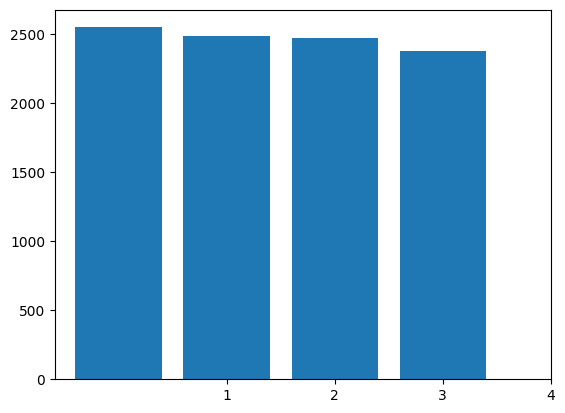

In [ ]:
count=pd.Series(targets).value_counts()
plt.bar(count.index,count.values)
plt.xscale('linear')
plt.xticks(range(1,5,1))

### String -> Numeric
On va map nos données target pour faciliter l'entrainement de notre modèle
Celui-ci va prédir une donnée numérique en output et on calculera la loss par rapport à la value de la classe correspondante

In [ ]:
map = {
    'un': 1,
    'deux': 2,
    'trois': 3,
    'quatre': 4
}

targets = [map[i] for i in targets]

### Transformation de nos waveform en spectrogram

In [ ]:
transform = MelSpectrogram(sample_rate=48000, n_mels=40, n_fft=512, hop_length=256)
spectrograms = [transform(wave).squeeze(0) for wave in waveformes]

### Normalisation des données (Pour un CNN 25% -> 75% avec une normalisation standard)

In [ ]:
def normalize_spectrograms(spectrograms):
    normalized_spectrograms = []
    for s in spectrograms:
        mean = s.mean()
        std = s.std()
        normalized_spectrograms.append((s - mean) / std)
    return normalized_spectrograms

spectrograms = normalize_spectrograms(spectrograms)


In [ ]:
print(spectrograms[1].shape)

torch.Size([40, 370])


In [ ]:
print(spectrograms[0].shape)
print(spectrograms[0].shape[1])

torch.Size([40, 365])
365


In [ ]:
max = 0
for mel in spectrograms:
    if mel.shape[1] > max:
        max = mel.shape[1]

print(max)

2021


### On trasnpose notre tensor pour avoir les time frame en première dimension 

In [ ]:
spectrograms = [mel.transpose(0, 1) for mel in spectrograms]
print(spectrograms[0].shape)

torch.Size([365, 40])


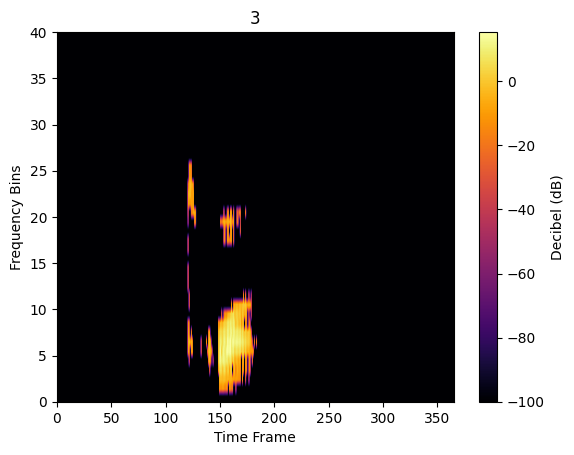

In [ ]:
def plot_spectrogram(spec, title=None, ylabel='Frequency Bins', aspect='auto', xmax=None):
    """
    Plots a spectrogram with the time axis on the x-axis and frequency bins on the y-axis.
    
    Parameters:
        spec (np.ndarray or torch.Tensor): The spectrogram tensor/array.
        title (str, optional): Title of the plot.
        ylabel (str, optional): Label for the y-axis.
        aspect (str, optional): Aspect ratio of the plot. 'auto' fills the axes with the data.
        xmax (int, optional): Maximum value for the x-axis (time axis).
    """
    # Transform amplitude spectrogram to decibel scale
    spec_to_db = T.AmplitudeToDB(stype='power')
    spec_db = spec_to_db(spec)

    # Check if the input is a tensor and convert to numpy for plotting
    if isinstance(spec_db, torch.Tensor):
        spec_db = spec_db.numpy()

    # Transpose the spectrogram to align time on the x-axis and frequency bins on the y-axis
    spec_db = spec_db.T  # now the shape should be [time, frequency]

    # Create the plot
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or 'Spectrogram (dB)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('Time Frame')
    
    # Adjust the extent to properly scale the axes, with time on the x-axis and frequency on the y-axis
    cax = axs.imshow(spec_db, aspect=aspect, origin='lower',
                     extent=[0, spec_db.shape[1], 0, spec_db.shape[0]],
                     cmap='inferno')
    
    # Set maximum x-axis value if provided
    if xmax:
        axs.set_xlim([0, xmax])
    
    # Add a colorbar to the plot to indicate the decibel scale
    fig.colorbar(cax, label='Decibel (dB)')
    plt.show()

plot_spectrogram(spectrograms[0].squeeze(0), title=targets[0])

### Padding 
Pour avoir des séquence de même données 

In [ ]:
def pad(spectrograms,max):
    padded_spectrograms = []
    for mel in spectrograms:
        padded_spectrograms.append(F.pad(mel, (0, 0, 0, max-mel.shape[0])))
    return padded_spectrograms
padded_spectrograms = pad(spectrograms,max)

In [ ]:
print(padded_spectrograms[1].shape)


torch.Size([2021, 40])


### Séparation 80/20

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_spectrograms, targets, test_size=0.2, random_state=42)

In [ ]:
print(len(X_train))
print(len(X_test))

7904
1977


In [ ]:
# Stack permet de transformer une liste de tensor en un seul tensor
X_train_tensor = torch.stack(X_train)
X_test_tensor = torch.stack(X_test)  

y_train_tensor = torch.tensor(y_train).long() 
y_test_tensor = torch.tensor(y_test).long()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
print(len(train_dataset))
print(len(test_dataset))

7904
1977


In [ ]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

## CNN 

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(5, 5), stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=(4, 2), stride=(4, 2))

        self.conv2 = nn.Conv2d(8, 16, kernel_size=(5, 5), stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=(4, 2), stride=(4, 2))
        self.flattened_size = 16 * 126 * 10

        self.fc1 = nn.Linear(self.flattened_size, 2048)
        self.fc2 = nn.Linear(2048, num_classes)
        self.dropout = nn.Dropout(0.3)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.dropout(x)
        x = x.view(-1, self.flattened_size) 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
cnn = SimpleCNN(4).to(device)

### Function Train/Test

In [ ]:
def train_cnn(model, train_loader, optimizer, criterion, epochs=20):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        with tqdm(train_loader, unit="batch") as tepoch:
            for spectrograms, labels in tepoch:
                tepoch.set_description(f"Epoch {epoch+1}")
                
                spectrograms = spectrograms.to(device)
                labels = labels.to(device)
                outputs = model(spectrograms.unsqueeze(1))  
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())
        
        # Average loss for this epoch
        average_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1} completed: Avg. Loss: {average_loss:.4f}")

In [ ]:
def test_cnn(model, test_loader):
    with torch.no_grad():
        acc_total = 0
        model.eval()
        for spectrograms, labels in test_loader:
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)
            outputs = model(spectrograms.unsqueeze(1))
            _, predicted = torch.max(outputs, 1)
            acc_total += (predicted==labels).sum().item()/len(labels)
        print(f"Accuracy: {acc_total/len(test_loader)}")

### Train/Test

In [ ]:
# Train CNN
optimizer = torch.optim.AdamW(lr=0.0001, params=cnn.parameters())
criterion = nn.CrossEntropyLoss()
train_cnn(cnn, train_loader, optimizer, criterion, epochs=10)

Epoch 1: 100%|██████████| 62/62 [00:11<00:00,  5.39batch/s, loss=0.354]


Epoch 1 completed: Avg. Loss: 0.5755


Epoch 2: 100%|██████████| 62/62 [00:10<00:00,  6.13batch/s, loss=0.221]


Epoch 2 completed: Avg. Loss: 0.3439


Epoch 3: 100%|██████████| 62/62 [00:09<00:00,  6.26batch/s, loss=0.259]


Epoch 3 completed: Avg. Loss: 0.2879


Epoch 4: 100%|██████████| 62/62 [00:09<00:00,  6.52batch/s, loss=0.215]


Epoch 4 completed: Avg. Loss: 0.2525


Epoch 5: 100%|██████████| 62/62 [00:09<00:00,  6.26batch/s, loss=0.196]


Epoch 5 completed: Avg. Loss: 0.2241


Epoch 6: 100%|██████████| 62/62 [00:09<00:00,  6.55batch/s, loss=0.141]


Epoch 6 completed: Avg. Loss: 0.2025


Epoch 7: 100%|██████████| 62/62 [00:09<00:00,  6.34batch/s, loss=0.308] 


Epoch 7 completed: Avg. Loss: 0.1803


Epoch 8: 100%|██████████| 62/62 [00:09<00:00,  6.44batch/s, loss=0.187] 


Epoch 8 completed: Avg. Loss: 0.1717


Epoch 9: 100%|██████████| 62/62 [00:10<00:00,  6.09batch/s, loss=0.161] 


Epoch 9 completed: Avg. Loss: 0.1564


Epoch 10: 100%|██████████| 62/62 [00:10<00:00,  5.97batch/s, loss=0.164] 

Epoch 10 completed: Avg. Loss: 0.1488


In [ ]:
# Test CNN
test_cnn(cnn, test_loader)

Accuracy: 0.7182291666666667


## LSTM

In [ ]:
print(train_dataset[0][0].shape[1])

40


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, sequence_length, dropout):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.sequence_length = sequence_length
        self.dropout = dropout
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size*sequence_length, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, (_,_) = self.lstm(x, (h0, c0))
        # out = self.fc(out[:, -1, :])
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out

In [ ]:
acc = []
def train_lstm(model, train_loader, optimizer, criterion, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        with tqdm(train_loader, unit="batch") as tepoch:
            for spectrograms, labels in tepoch:
                tepoch.set_description(f"Epoch {epoch+1}")
                spectrograms = spectrograms.to(device)
                labels = labels.to(device)
                outputs = model(spectrograms)  
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())
        
        # Average loss for this epoch
        average_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1} completed: Avg. Loss: {average_loss:.4f}")
        acc.append(average_loss)

In [ ]:
def test_lstm(model, test_loader):
    with torch.no_grad():
        acc_total = 0
        model.eval()
        for spectrograms, labels in test_loader:
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)
            outputs = model(spectrograms)
            _, predicted = torch.max(outputs, 1)
            acc_total += (predicted==labels).sum().item()/len(labels)
        print(f"Accuracy: {acc_total/len(test_loader)}")

In [ ]:
num_layers = 4
hidden_size = 50
# Input_size = n filter
input_size = train_dataset[0][0].shape[1]
# Séquence length = padding = 2021
sequence_length = train_dataset[0][0].shape[0]
num_classes = 6
dropout = 0.2
lr = 0.0001
num_epochs = 77


lstm = LSTM(input_size, hidden_size, num_layers, num_classes, sequence_length, dropout)
lstm.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm.parameters(), lr=lr)
train_lstm(lstm, train_loader, optimizer, criterion, epochs=num_epochs)


Epoch 1:   0%|          | 0/62 [00:00<?, ?batch/s]

Epoch 1: 100%|██████████| 62/62 [00:43<00:00,  1.43batch/s, loss=1]    


Epoch 1 completed: Avg. Loss: 1.2577


Epoch 2: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.639]


Epoch 2 completed: Avg. Loss: 0.8224


Epoch 3: 100%|██████████| 62/62 [00:42<00:00,  1.48batch/s, loss=0.607]


Epoch 3 completed: Avg. Loss: 0.6279


Epoch 4: 100%|██████████| 62/62 [00:42<00:00,  1.47batch/s, loss=0.382]


Epoch 4 completed: Avg. Loss: 0.4999


Epoch 5: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.401]


Epoch 5 completed: Avg. Loss: 0.4183


Epoch 6: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.343]


Epoch 6 completed: Avg. Loss: 0.3481


Epoch 7: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.368]


Epoch 7 completed: Avg. Loss: 0.3001


Epoch 8: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.185]


Epoch 8 completed: Avg. Loss: 0.2630


Epoch 9: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.2]  


Epoch 9 completed: Avg. Loss: 0.2317


Epoch 10: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.192]


Epoch 10 completed: Avg. Loss: 0.2095


Epoch 11: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.2]  


Epoch 11 completed: Avg. Loss: 0.1925


Epoch 12: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.122] 


Epoch 12 completed: Avg. Loss: 0.1721


Epoch 13: 100%|██████████| 62/62 [00:42<00:00,  1.48batch/s, loss=0.128] 


Epoch 13 completed: Avg. Loss: 0.1525


Epoch 14: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.126] 


Epoch 14 completed: Avg. Loss: 0.1390


Epoch 15: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.0904]


Epoch 15 completed: Avg. Loss: 0.1320


Epoch 16: 100%|██████████| 62/62 [00:42<00:00,  1.47batch/s, loss=0.204] 


Epoch 16 completed: Avg. Loss: 0.1194


Epoch 17: 100%|██████████| 62/62 [00:42<00:00,  1.45batch/s, loss=0.1]   


Epoch 17 completed: Avg. Loss: 0.1091


Epoch 18: 100%|██████████| 62/62 [00:42<00:00,  1.47batch/s, loss=0.0774]


Epoch 18 completed: Avg. Loss: 0.1044


Epoch 19: 100%|██████████| 62/62 [00:42<00:00,  1.47batch/s, loss=0.0785]


Epoch 19 completed: Avg. Loss: 0.0925


Epoch 20: 100%|██████████| 62/62 [00:42<00:00,  1.47batch/s, loss=0.0863]


Epoch 20 completed: Avg. Loss: 0.0830


Epoch 21: 100%|██████████| 62/62 [00:42<00:00,  1.47batch/s, loss=0.125] 


Epoch 21 completed: Avg. Loss: 0.0849


Epoch 22: 100%|██████████| 62/62 [00:42<00:00,  1.47batch/s, loss=0.0195]


Epoch 22 completed: Avg. Loss: 0.0731


Epoch 23: 100%|██████████| 62/62 [00:42<00:00,  1.47batch/s, loss=0.0485]


Epoch 23 completed: Avg. Loss: 0.0780


Epoch 24: 100%|██████████| 62/62 [00:42<00:00,  1.47batch/s, loss=0.0725]


Epoch 24 completed: Avg. Loss: 0.0682


Epoch 25: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.0677]


Epoch 25 completed: Avg. Loss: 0.0626


Epoch 26: 100%|██████████| 62/62 [00:42<00:00,  1.45batch/s, loss=0.0423]


Epoch 26 completed: Avg. Loss: 0.0629


Epoch 27: 100%|██████████| 62/62 [00:43<00:00,  1.44batch/s, loss=0.0409]


Epoch 27 completed: Avg. Loss: 0.0536


Epoch 28: 100%|██████████| 62/62 [00:50<00:00,  1.22batch/s, loss=0.0757]


Epoch 28 completed: Avg. Loss: 0.0530


Epoch 29: 100%|██████████| 62/62 [00:42<00:00,  1.45batch/s, loss=0.0423]


Epoch 29 completed: Avg. Loss: 0.0530


Epoch 30: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.0573]


Epoch 30 completed: Avg. Loss: 0.0468


Epoch 31: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.021] 


Epoch 31 completed: Avg. Loss: 0.0477


Epoch 32: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.0251]


Epoch 32 completed: Avg. Loss: 0.0402


Epoch 33: 100%|██████████| 62/62 [00:42<00:00,  1.47batch/s, loss=0.0163]


Epoch 33 completed: Avg. Loss: 0.0428


Epoch 34: 100%|██████████| 62/62 [00:42<00:00,  1.47batch/s, loss=0.0301]


Epoch 34 completed: Avg. Loss: 0.0380


Epoch 35: 100%|██████████| 62/62 [00:42<00:00,  1.45batch/s, loss=0.0267]


Epoch 35 completed: Avg. Loss: 0.0385


Epoch 36: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.0422]


Epoch 36 completed: Avg. Loss: 0.0365


Epoch 37: 100%|██████████| 62/62 [00:42<00:00,  1.46batch/s, loss=0.0502] 


Epoch 37 completed: Avg. Loss: 0.0337


Epoch 38: 100%|██████████| 62/62 [00:42<00:00,  1.46batch/s, loss=0.0625] 


Epoch 38 completed: Avg. Loss: 0.0343


Epoch 39: 100%|██████████| 62/62 [00:42<00:00,  1.46batch/s, loss=0.0345] 


Epoch 39 completed: Avg. Loss: 0.0333


Epoch 40: 100%|██████████| 62/62 [00:42<00:00,  1.46batch/s, loss=0.0226] 


Epoch 40 completed: Avg. Loss: 0.0258


Epoch 41: 100%|██████████| 62/62 [00:43<00:00,  1.43batch/s, loss=0.0134] 


Epoch 41 completed: Avg. Loss: 0.0268


Epoch 42: 100%|██████████| 62/62 [00:42<00:00,  1.45batch/s, loss=0.0408] 


Epoch 42 completed: Avg. Loss: 0.0266


Epoch 43: 100%|██████████| 62/62 [00:42<00:00,  1.47batch/s, loss=0.0604] 


Epoch 43 completed: Avg. Loss: 0.0262


Epoch 44: 100%|██████████| 62/62 [00:42<00:00,  1.46batch/s, loss=0.0359] 


Epoch 44 completed: Avg. Loss: 0.0256


Epoch 45: 100%|██████████| 62/62 [00:42<00:00,  1.46batch/s, loss=0.0064] 


Epoch 45 completed: Avg. Loss: 0.0243


Epoch 46: 100%|██████████| 62/62 [00:42<00:00,  1.46batch/s, loss=0.0212] 


Epoch 46 completed: Avg. Loss: 0.0241


Epoch 47: 100%|██████████| 62/62 [00:42<00:00,  1.47batch/s, loss=0.00827]


Epoch 47 completed: Avg. Loss: 0.0222


Epoch 48: 100%|██████████| 62/62 [00:42<00:00,  1.47batch/s, loss=0.0359] 


Epoch 48 completed: Avg. Loss: 0.0228


Epoch 49: 100%|██████████| 62/62 [00:42<00:00,  1.45batch/s, loss=0.0233] 


Epoch 49 completed: Avg. Loss: 0.0210


Epoch 50: 100%|██████████| 62/62 [00:42<00:00,  1.47batch/s, loss=0.0174] 


Epoch 50 completed: Avg. Loss: 0.0167


Epoch 51: 100%|██████████| 62/62 [00:42<00:00,  1.46batch/s, loss=0.0106] 


Epoch 51 completed: Avg. Loss: 0.0186


Epoch 52: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.00516]


Epoch 52 completed: Avg. Loss: 0.0157


Epoch 53: 100%|██████████| 62/62 [00:42<00:00,  1.46batch/s, loss=0.00575]


Epoch 53 completed: Avg. Loss: 0.0159


Epoch 54: 100%|██████████| 62/62 [00:43<00:00,  1.44batch/s, loss=0.0108] 


Epoch 54 completed: Avg. Loss: 0.0186


Epoch 55: 100%|██████████| 62/62 [00:42<00:00,  1.46batch/s, loss=0.0138] 


Epoch 55 completed: Avg. Loss: 0.0154


Epoch 56: 100%|██████████| 62/62 [00:42<00:00,  1.46batch/s, loss=0.00474]


Epoch 56 completed: Avg. Loss: 0.0129


Epoch 57: 100%|██████████| 62/62 [00:42<00:00,  1.46batch/s, loss=0.00188]


Epoch 57 completed: Avg. Loss: 0.0146


Epoch 58: 100%|██████████| 62/62 [00:42<00:00,  1.45batch/s, loss=0.00738]


Epoch 58 completed: Avg. Loss: 0.0177


Epoch 59: 100%|██████████| 62/62 [00:42<00:00,  1.46batch/s, loss=0.0116] 


Epoch 59 completed: Avg. Loss: 0.0148


Epoch 60: 100%|██████████| 62/62 [00:42<00:00,  1.47batch/s, loss=0.00537]


Epoch 60 completed: Avg. Loss: 0.0121


Epoch 61: 100%|██████████| 62/62 [00:42<00:00,  1.46batch/s, loss=0.0109] 


Epoch 61 completed: Avg. Loss: 0.0158


Epoch 62: 100%|██████████| 62/62 [00:42<00:00,  1.47batch/s, loss=0.00597]


Epoch 62 completed: Avg. Loss: 0.0123


Epoch 63: 100%|██████████| 62/62 [00:42<00:00,  1.46batch/s, loss=0.0203] 


Epoch 63 completed: Avg. Loss: 0.0120


Epoch 64: 100%|██████████| 62/62 [00:42<00:00,  1.46batch/s, loss=0.0138] 


Epoch 64 completed: Avg. Loss: 0.0108


Epoch 65: 100%|██████████| 62/62 [00:42<00:00,  1.46batch/s, loss=0.00122] 


Epoch 65 completed: Avg. Loss: 0.0111


Epoch 66: 100%|██████████| 62/62 [00:42<00:00,  1.46batch/s, loss=0.0049]  


Epoch 66 completed: Avg. Loss: 0.0094


Epoch 67: 100%|██████████| 62/62 [00:42<00:00,  1.44batch/s, loss=0.00538] 


Epoch 67 completed: Avg. Loss: 0.0090


Epoch 68: 100%|██████████| 62/62 [00:42<00:00,  1.45batch/s, loss=0.0123]  


Epoch 68 completed: Avg. Loss: 0.0098


Epoch 69: 100%|██████████| 62/62 [00:42<00:00,  1.46batch/s, loss=0.0728]  


Epoch 69 completed: Avg. Loss: 0.0082


Epoch 70: 100%|██████████| 62/62 [00:42<00:00,  1.47batch/s, loss=0.00213]


Epoch 70 completed: Avg. Loss: 0.0107


Epoch 71: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.00613] 


Epoch 71 completed: Avg. Loss: 0.0080


Epoch 72: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.00478] 


Epoch 72 completed: Avg. Loss: 0.0075


Epoch 73: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.00554] 


Epoch 73 completed: Avg. Loss: 0.0066


Epoch 74: 100%|██████████| 62/62 [00:41<00:00,  1.48batch/s, loss=0.00298] 


Epoch 74 completed: Avg. Loss: 0.0080


Epoch 75: 100%|██████████| 62/62 [00:42<00:00,  1.47batch/s, loss=0.0192]  


Epoch 75 completed: Avg. Loss: 0.0093


Epoch 76: 100%|██████████| 62/62 [00:42<00:00,  1.48batch/s, loss=0.00283]


Epoch 76 completed: Avg. Loss: 0.0078


Epoch 77: 100%|██████████| 62/62 [00:42<00:00,  1.47batch/s, loss=0.00729]

Epoch 77 completed: Avg. Loss: 0.0087


In [ ]:
test_lstm(lstm, test_loader)

Accuracy: 0.9822916666666667


In [ ]:
torch.save(lstm.state_dict(), 'lstm98-77epch.pth')